# Predicting Animal Crossing Item Prices

Animal Crossing is a cute lifestyle game where you create your own island and customize it by crafting and buying different items. 

What factors determine item prices? Is it the type of item? Is it whether the item is craftable? Maybe it's the ability to interact with it? 

I try to find out what qualities an item has that determines its price by creating a correlation heatmap and then I create a KNN and Linear Regression machine learning model using correlated features to find out!

Dataset is from: https://www.kaggle.com/datasets/jessicali9530/animal-crossing-new-horizons-nookplaza-dataset

In [637]:
#Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Predicting Houseware Prices

We're predicting houseware prices because it is the largest dataset of items within the Animal Crossing item catalog.

First, we read in the data and explore it to figure out what needs to be cleaned.

In [638]:
housewares = pd.read_csv(r'C:\Users\Isabella\Documents\Projects\AC Price Predictor\animal crossing catalog\housewares.csv')
housewares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3275 non-null   object 
 1   Variation          3074 non-null   object 
 2   Body Title         1182 non-null   object 
 3   Pattern            1508 non-null   object 
 4   Pattern Title      1508 non-null   object 
 5   DIY                3275 non-null   object 
 6   Body Customize     3275 non-null   object 
 7   Pattern Customize  3275 non-null   object 
 8   Kit Cost           2239 non-null   float64
 9   Buy                3275 non-null   object 
 10  Sell               3275 non-null   int64  
 11  Color 1            3275 non-null   object 
 12  Color 2            3275 non-null   object 
 13  Size               3275 non-null   object 
 14  Miles Price        115 non-null    float64
 15  Source             3275 non-null   object 
 16  Source Notes       1870 

In [639]:
housewares.head()

,Name,Variation,Body Title,Pattern,Pattern Title,DIY,Body Customize,Pattern Customize,Kit Cost,Buy,...,Interact,Tag,Outdoor,Speaker Type,Lighting Type,Catalog,Filename,Variant ID,Internal ID,Unique Entry ID
0,acoustic guitar,Natural,Body,NaN,NaN,Yes,Yes,No,5.0,NFS,...,Yes,Musical Instrument,No,Does not play music,No lighting,Not for sale,FtrAcorsticguitar_Remake_0_0,0_0,383,EpywQXABBcv2dipsP
1,acoustic guitar,Cherry,Body,NaN,NaN,Yes,Yes,No,5.0,NFS,...,Yes,Musical Instrument,No,Does not play music,No lighting,Not for sale,FtrAcorsticguitar_Remake_1_0,1_0,383,K9she5Y4SuXA8MGBR
2,acoustic guitar,Brown,Body,NaN,NaN,Yes,Yes,No,5.0,NFS,...,Yes,Musical Instrument,No,Does not play music,No lighting,Not for sale,FtrAcorsticguitar_Remake_2_0,2_0,383,vLq9iphAvALBXazDr
3,acoustic guitar,Blue,Body,NaN,NaN,Yes,Yes,No,5.0,NFS,...,Yes,Musical Instrument,No,Does not play music,No lighting,Not for sale,FtrAcorsticguitar_Remake_3_0,3_0,383,nuqeFzNE5PneqGHaj
4,acoustic guitar,White,Body,NaN,NaN,Yes,Yes,No,5.0,NFS,...,Yes,Musical Instrument,No,Does not play music,No lighting,Not for sale,FtrAcorsticguitar_Remake_4_0,4_0,383,DotFsojrhCwrLZ3TF


## Removing unnecessary columns

The following columns are Body/Pattern related with more than half NaN entries, unique ID numbers to each item, are notes for the developers (and thus do not have any bearing on the price of the item), or (in the case of the Color columns) they only state the colors of the object, which is already done in the Variation column. So they will not be considered for this project and will instead be dropped.

- Body Title
- Pattern
- Pattern Title 
- Unique Entry ID 
- Internal ID 
- Variant ID
- Filename
- HHA Concept 1
- HHA Concept 2 
- HHA Series
- HHA Set
- Version 
- Source Notes
- Color 1
- Color 2
- Kit Cost (not the price we're looking at for this project)
- Sell (We are only considering the price to buy an item)
- Lighting Type (The vast majority of the items are not lighting objects so this column does not contain very useful information)
- Speaker Type (Same as the Lighting Type column)

In [640]:
housewares = housewares.drop(['Body Title', 'Pattern', 'Pattern Title', 'Sell', 'Color 1', 'Color 2', 'Version', 'Source Notes', 'HHA Concept 1', 'HHA Concept 2', 'HHA Series', 'HHA Set', 'Unique Entry ID', 'Internal ID', 'Variant ID', 'Filename', 'Kit Cost', 'Speaker Type', 'Lighting Type'], axis=1)
print(housewares.columns)

Index(['Name', 'Variation', 'DIY', 'Body Customize', 'Pattern Customize',
       'Buy', 'Size', 'Miles Price', 'Source', 'Interact', 'Tag', 'Outdoor',
       'Catalog'],
      dtype='object')


## Cleaning up the different item variations

The code below shows the number of variations each item has. We don't want each of the variations since the price of each item is the same regardless of the variation--instead, we'd like to combine each variation of the item into one and then add the number of variations instead of considering each variation as its own item.

To do this, we'll create a new column called  the `VariationCount` column with the number of variations, drop the `Variation` column, and then remove the duplicate rows. 

In [641]:
housewares['Name'].value_counts()

simple panel            64
changing room           64
loft bed with desk      64
rock guitar             64
electric guitar         56
                        ..
silver mic               1
simple DIY workbench     1
simple well              1
skeleton                 1
sandbox                  1
Name: Name, Length: 532, dtype: int64

In [642]:
housewares['VariationCount'] = housewares['Name'].map(housewares['Name'].value_counts())

In [643]:
housewares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3275 non-null   object 
 1   Variation          3074 non-null   object 
 2   DIY                3275 non-null   object 
 3   Body Customize     3275 non-null   object 
 4   Pattern Customize  3275 non-null   object 
 5   Buy                3275 non-null   object 
 6   Size               3275 non-null   object 
 7   Miles Price        115 non-null    float64
 8   Source             3275 non-null   object 
 9   Interact           3275 non-null   object 
 10  Tag                3275 non-null   object 
 11  Outdoor            3275 non-null   object 
 12  Catalog            3275 non-null   object 
 13  VariationCount     3275 non-null   int64  
dtypes: float64(1), int64(1), object(12)
memory usage: 358.3+ KB


In [644]:
housewares = housewares.drop('Variation', axis=1)
housewares.head()

,Name,DIY,Body Customize,Pattern Customize,Buy,Size,Miles Price,Source,Interact,Tag,Outdoor,Catalog,VariationCount
0,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7
1,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7
2,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7
3,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7
4,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7


In [645]:
housewares = housewares.drop_duplicates().reset_index()
housewares = housewares.drop('index', axis = 1)
housewares.head()

,Name,DIY,Body Customize,Pattern Customize,Buy,Size,Miles Price,Source,Interact,Tag,Outdoor,Catalog,VariationCount
0,acoustic guitar,Yes,Yes,No,NFS,1x1,NaN,Crafting,Yes,Musical Instrument,No,Not for sale,7
1,air circulator,No,No,No,1100,1x1,NaN,Nook's Cranny,Yes,Fan,Yes,For sale,5
2,alto saxophone,No,No,No,3400,1x1,NaN,Nook's Cranny,Yes,Musical Instrument,No,For sale,1
3,anatomical model,No,No,No,3500,1x1,NaN,Nook's Cranny,No,Hospital,No,For sale,1
4,anchor statue,No,Yes,No,NFS,1x1,NaN,Fishing Tourney,No,Seaside,Yes,Not for sale,6


##  Cleaning up columns and removing Miles Only items

Now that the columns have been decided on, it's time to clean up columns with NaN values, convert Yes/No entries to True/False, change the datatypes for each column so they can be analyzed, and separate the dataset into items that cost Miles and items that cost Bells.

In [646]:
housewares = housewares.replace('Yes', True)
housewares = housewares.replace('No', False)

In [647]:
housewares.head()
housewares.shape

(546, 13)

In [648]:
housewares['Buy'].value_counts()
#The number of items we're considering will be 546-292=254

NFS       292
3500        9
1100        8
2700        8
3000        7
         ... 
260000      1
23000       1
29000       1
73000       1
500         1
Name: Buy, Length: 114, dtype: int64

In [649]:
housewares['Miles Price'].value_counts()

1000.0    5
2000.0    5
5000.0    4
4000.0    4
2400.0    3
3000.0    2
Name: Miles Price, dtype: int64

In [650]:
housewares['Miles Price'] = housewares['Miles Price'].replace(np.nan, 'NFS with Miles')

In [651]:
housewares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               546 non-null    object
 1   DIY                546 non-null    bool  
 2   Body Customize     546 non-null    bool  
 3   Pattern Customize  546 non-null    bool  
 4   Buy                546 non-null    object
 5   Size               546 non-null    object
 6   Miles Price        546 non-null    object
 7   Source             546 non-null    object
 8   Interact           546 non-null    object
 9   Tag                546 non-null    object
 10  Outdoor            546 non-null    bool  
 11  Catalog            546 non-null    object
 12  VariationCount     546 non-null    int64 
dtypes: bool(4), int64(1), object(8)
memory usage: 40.6+ KB


The datatypes should be as follows:

| Column | Wanted Datatype | Already Correct? |
| --- | --- | --- |
| Name | String | No |
| DIY | Bool | Yes | 
| Body Customize | Bool | Yes | 
| Pattern Customize | Bool | Yes |
| Buy | Int | No |
| Size | Int | No | 
| Miles Price | Int | No |
| Source | String | No |
| Interact | Bool | No |
| Tag | String | No |
| Outdoor | Bool | Yes |
| Speaker Type | String | No |
| Lighting Type | String | No | 
| Catalog | Bool | No |
| VariationCount | Int | Yes |

In [652]:
nfs_bool = housewares['Buy'] == 'NFS'
bells_bool = housewares['Miles Price'] != 'NFS with Miles'
housewares_m = housewares[nfs_bool & bells_bool]
housewares_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 102 to 515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               23 non-null     object
 1   DIY                23 non-null     bool  
 2   Body Customize     23 non-null     bool  
 3   Pattern Customize  23 non-null     bool  
 4   Buy                23 non-null     object
 5   Size               23 non-null     object
 6   Miles Price        23 non-null     object
 7   Source             23 non-null     object
 8   Interact           23 non-null     object
 9   Tag                23 non-null     object
 10  Outdoor            23 non-null     bool  
 11  Catalog            23 non-null     object
 12  VariationCount     23 non-null     int64 
dtypes: bool(4), int64(1), object(8)
memory usage: 1.9+ KB


In [653]:
housewares_b = housewares[housewares['Buy'] != 'NFS']
housewares_b.drop('Miles Price', axis = 1)
housewares_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 1 to 544
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               254 non-null    object
 1   DIY                254 non-null    bool  
 2   Body Customize     254 non-null    bool  
 3   Pattern Customize  254 non-null    bool  
 4   Buy                254 non-null    object
 5   Size               254 non-null    object
 6   Miles Price        254 non-null    object
 7   Source             254 non-null    object
 8   Interact           254 non-null    object
 9   Tag                254 non-null    object
 10  Outdoor            254 non-null    bool  
 11  Catalog            254 non-null    object
 12  VariationCount     254 non-null    int64 
dtypes: bool(4), int64(1), object(8)
memory usage: 20.8+ KB


In [654]:
#we'll cast the Size column as a string for now but will change it to int using eval later
housewares_b = housewares_b.astype({"Name": str, "Buy": int, "Size": str, "Source": str, "Interact": bool, "Tag": str, "Catalog": bool})
housewares_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 1 to 544
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               254 non-null    object
 1   DIY                254 non-null    bool  
 2   Body Customize     254 non-null    bool  
 3   Pattern Customize  254 non-null    bool  
 4   Buy                254 non-null    int32 
 5   Size               254 non-null    object
 6   Miles Price        254 non-null    object
 7   Source             254 non-null    object
 8   Interact           254 non-null    bool  
 9   Tag                254 non-null    object
 10  Outdoor            254 non-null    bool  
 11  Catalog            254 non-null    bool  
 12  VariationCount     254 non-null    int64 
dtypes: bool(6), int32(1), int64(1), object(5)
memory usage: 16.4+ KB


In [655]:
housewares_b['Size'] = housewares_b['Size'].replace("x", "*", regex=True)
housewares_b['Size'] = housewares_b['Size'].map(pd.eval).astype(int)
print(housewares_b['Size'])

1      1
2      1
3      1
6      4
7      1
      ..
516    1
540    1
541    2
543    1
544    1
Name: Size, Length: 254, dtype: int32


Now we'll check each column to make sure that all the columns contain useful information. If it has all the same values or almost all the same values, we'll drop it from the dataset since it won't give us any important information.

In [656]:
housewares_b['DIY'].value_counts()

False    254
Name: DIY, dtype: int64

In [657]:
housewares_b['Body Customize'].value_counts()

False    246
True       8
Name: Body Customize, dtype: int64

In [658]:
housewares_b['Catalog'].value_counts()

True    254
Name: Catalog, dtype: int64

The DIY and Catalog columns have the same value for every object and the Body Customize column is only different for 8 items, giving us very little information. So we'll drop them. 

We'll also drop the Miles Price column since we've isolated only the items that are bought with Bells

In [659]:
housewares_b = housewares_b.drop(['DIY', 'Body Customize', 'Catalog', 'Miles Price'], axis=1)
housewares_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 1 to 544
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               254 non-null    object
 1   Pattern Customize  254 non-null    bool  
 2   Buy                254 non-null    int32 
 3   Size               254 non-null    int32 
 4   Source             254 non-null    object
 5   Interact           254 non-null    bool  
 6   Tag                254 non-null    object
 7   Outdoor            254 non-null    bool  
 8   VariationCount     254 non-null    int64 
dtypes: bool(3), int32(2), int64(1), object(3)
memory usage: 12.7+ KB


For the remaining object datatype columns, we'll convert them to numeric columns using dummy columns.

In [660]:
dummy_cols = pd.DataFrame()
dummy = pd.get_dummies(housewares_b['Source'])
housewares_b = pd.concat([housewares_b, dummy], axis=1)
del housewares_b['Source']

In [661]:
housewares_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 1 to 544
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Name                     254 non-null    object
 1   Pattern Customize        254 non-null    bool  
 2   Buy                      254 non-null    int32 
 3   Size                     254 non-null    int32 
 4   Interact                 254 non-null    bool  
 5   Tag                      254 non-null    object
 6   Outdoor                  254 non-null    bool  
 7   VariationCount           254 non-null    int64 
 8   Nook Shopping Promotion  254 non-null    uint8 
 9   Nook's Cranny            254 non-null    uint8 
 10  Starting items           254 non-null    uint8 
 11  Wedding Season           254 non-null    uint8 
dtypes: bool(3), int32(2), int64(1), object(2), uint8(4)
memory usage: 11.7+ KB


In [662]:
housewares_b['Wedding Season'].value_counts()

0    246
1      8
Name: Wedding Season, dtype: int64

In [663]:
housewares_b['Starting items'].value_counts()

0    253
1      1
Name: Starting items, dtype: int64

The Wedding Season and Starting Items columns do not contain useful information since less than 10 items are wedding/starting items, so we'll drop the columns.

In [664]:
housewares_b = housewares_b.drop(['Wedding Season', 'Starting items'], axis = 1)
print(housewares.columns)

Index(['Name', 'DIY', 'Body Customize', 'Pattern Customize', 'Buy', 'Size',
       'Miles Price', 'Source', 'Interact', 'Tag', 'Outdoor', 'Catalog',
       'VariationCount'],
      dtype='object')


## Determining features

Now that we have our final dataset of houseware items that can be bought with bells, it's time to start exploring the correlations between each feature and the price to figure out how to build our model.

We'll first start by splitting our dataset into two, getting the correlation matrix, and then mapping out the Pearson Correlation Coefficient for each set.

In [665]:
train = housewares_b[:127]
test = housewares_b[127:]

In [666]:
train_corr = train.corr()
print(train_corr)

                         Pattern Customize       Buy      Size  Interact  \
Pattern Customize                 1.000000 -0.130560  0.040048  0.006320   
Buy                              -0.130560  1.000000  0.256554  0.016388   
Size                              0.040048  0.256554  1.000000 -0.158658   
Interact                          0.006320  0.016388 -0.158658  1.000000   
Outdoor                          -0.002124 -0.177570 -0.131892 -0.011668   
VariationCount                    0.696413 -0.062042 -0.093517  0.069026   
Nook Shopping Promotion          -0.065240 -0.064075  0.011814 -0.114382   
Nook's Cranny                     0.075638  0.075177 -0.030423  0.068331   

                          Outdoor  VariationCount  Nook Shopping Promotion  \
Pattern Customize       -0.002124        0.696413                -0.065240   
Buy                     -0.177570       -0.062042                -0.064075   
Size                    -0.131892       -0.093517                 0.011814   
Int

<AxesSubplot:>

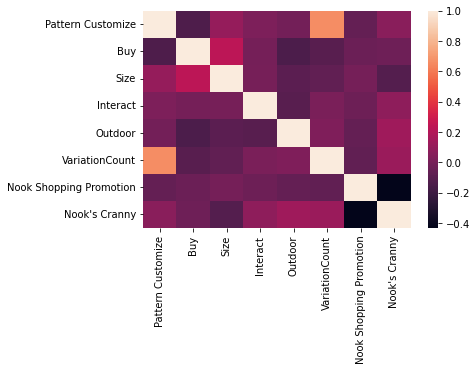

In [679]:
strong_corrs = test_corr[test_corr > .1]
corrmat = test[strong_corrs.index].corr()
sns.heatmap(corrmat)

<AxesSubplot:>

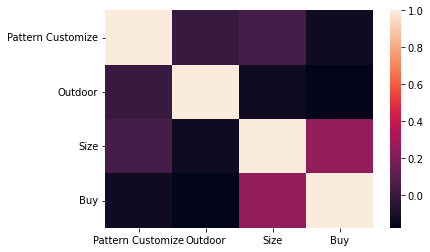

In [687]:
sorted_corrs = train_corr['Buy'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs > .1]
corrmat = train[strong_corrs.index].corr()
sns.heatmap(corrmat)

In [668]:
test_corr = test.corr()
print(test_corr)

                         Pattern Customize       Buy      Size  Interact  \
Pattern Customize                 1.000000 -0.139263  0.103121  0.021674   
Buy                              -0.139263  1.000000  0.231103 -0.004472   
Size                              0.103121  0.231103  1.000000  0.002903   
Interact                          0.021674 -0.004472  0.002903  1.000000   
Outdoor                          -0.008779 -0.145360 -0.094975 -0.105369   
VariationCount                    0.659231 -0.107400 -0.071881  0.009807   
Nook Shopping Promotion          -0.059485 -0.039416 -0.004825 -0.034037   
Nook's Cranny                     0.061569 -0.026910 -0.114736  0.078668   

                          Outdoor  VariationCount  Nook Shopping Promotion  \
Pattern Customize       -0.008779        0.659231                -0.059485   
Buy                     -0.145360       -0.107400                -0.039416   
Size                    -0.094975       -0.071881                -0.004825   
Int

<AxesSubplot:>

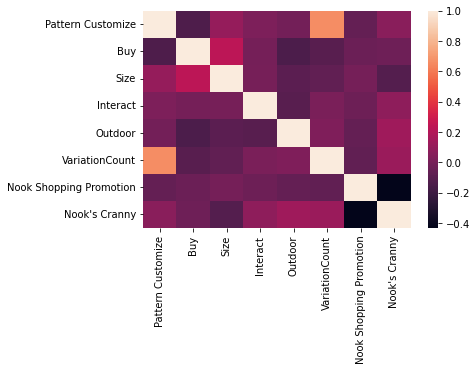

In [680]:
strong_corrs = test_corr[test_corr > .1]
corrmat = test[strong_corrs.index].corr()
sns.heatmap(corrmat)

<AxesSubplot:>

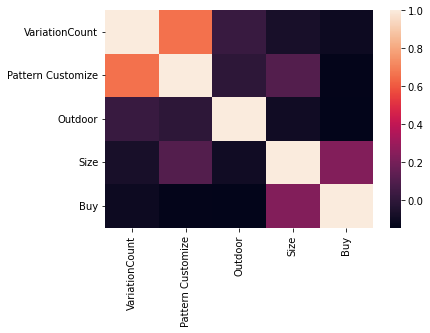

In [683]:
sorted_corrs = test_corr['Buy'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs > .1]
corrmat = test[strong_corrs.index].corr()
sns.heatmap(corrmat)

## KNN Single Variate Model

Looking at both the train and test dataset correlation maps, it looks like Size is the most correlated with the price of each item. We'll start by creating a KNN model using just the Size to predict the price of the item.